In [2]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import medfilt
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple
import os

from IPython.display import HTML

%matplotlib inline

In [3]:
# HELPER FUNCTIONS

# load dataset
def load_data(data_path, key_path):
    data = np.load(data_path, allow_pickle=True)
    key = np.load(key_path, allow_pickle=True).item()
    print("Loaded data and key.")
    print("Data shape: ", data.shape)
    print("Key length: ", len(key))
    return data, key

# plot force, position, and raw sensor data
def plot_initial_data(plot_data, plot_key):

    # plot force data over time
    force_fig, force_ax = plt.subplots(1,1)
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fx"]], label="Fx")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fy"]], label="Fy")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fz"]], label="Fz")
    force_ax.set_title("Force")
    force_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot x,y,z location over time
    loc_fig, loc_ax = plt.subplots(1,1)
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["x_act"]], label="x")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["y1_act"]], label="y")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["z_act"]], label="z")
    loc_ax.set_title("Location")
    loc_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot all sensor data over time
    sensor_fig, sensor_ax = plt.subplots(3,12, figsize=(80,20))
    sensor_keys = []
    for k in list(plot_key.keys()):
        if 's' in k: # TODO: this might break if we add more columns to the dataset
            sensor_keys.append(k)
    k = 0
    for i in range(3):
        for j in range(12):
            cur_key = sensor_keys[k]
            sensor_ax[i,j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key)
            sensor_ax[i,j].set_title(cur_key)
            sensor_ax[i,j].set_ylim(-35000, 35000)
            k += 1
    plt.show()

def plot_single_sensor_data(input_data, input_key, sensor_to_plot):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(input_data[:, input_key["time"]], input_data[:, input_key["Fz"]], label="Fz")
    ax[0].set_title("Fz")
    ax[1].plot(input_data[:, input_key["time"]], input_data[:, input_key["z_act"]], label="z")
    ax[1].set_title("z")
    ax[2].plot(input_data[:, input_key["time"]], input_data[:, input_key[sensor_to_plot]], label=sensor_to_plot)
    ax[2].set_title(sensor_to_plot)
    plt.tight_layout()
    plt.show()


Loaded data and key.
Data shape:  (152275, 51)
Key length:  51


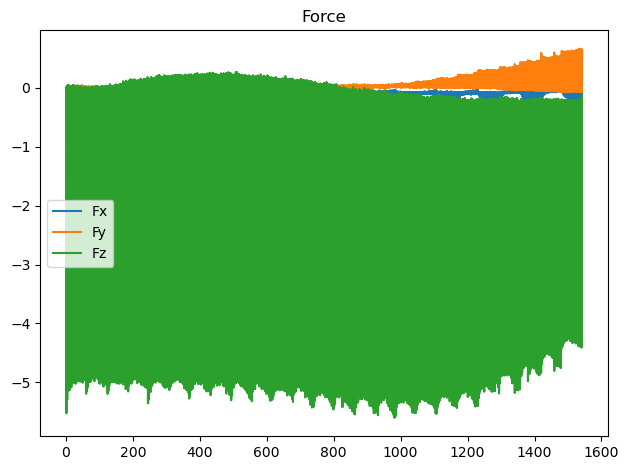

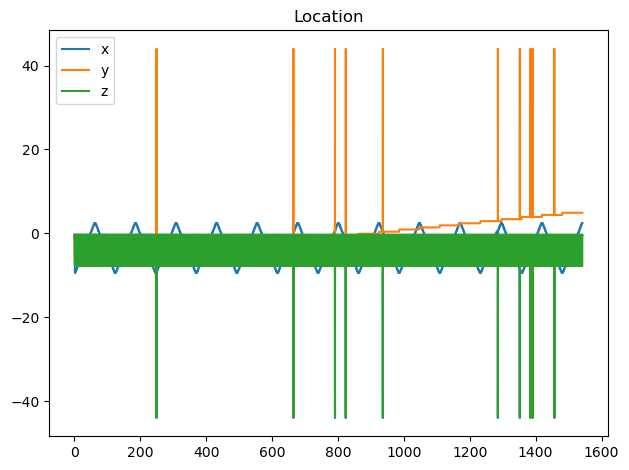

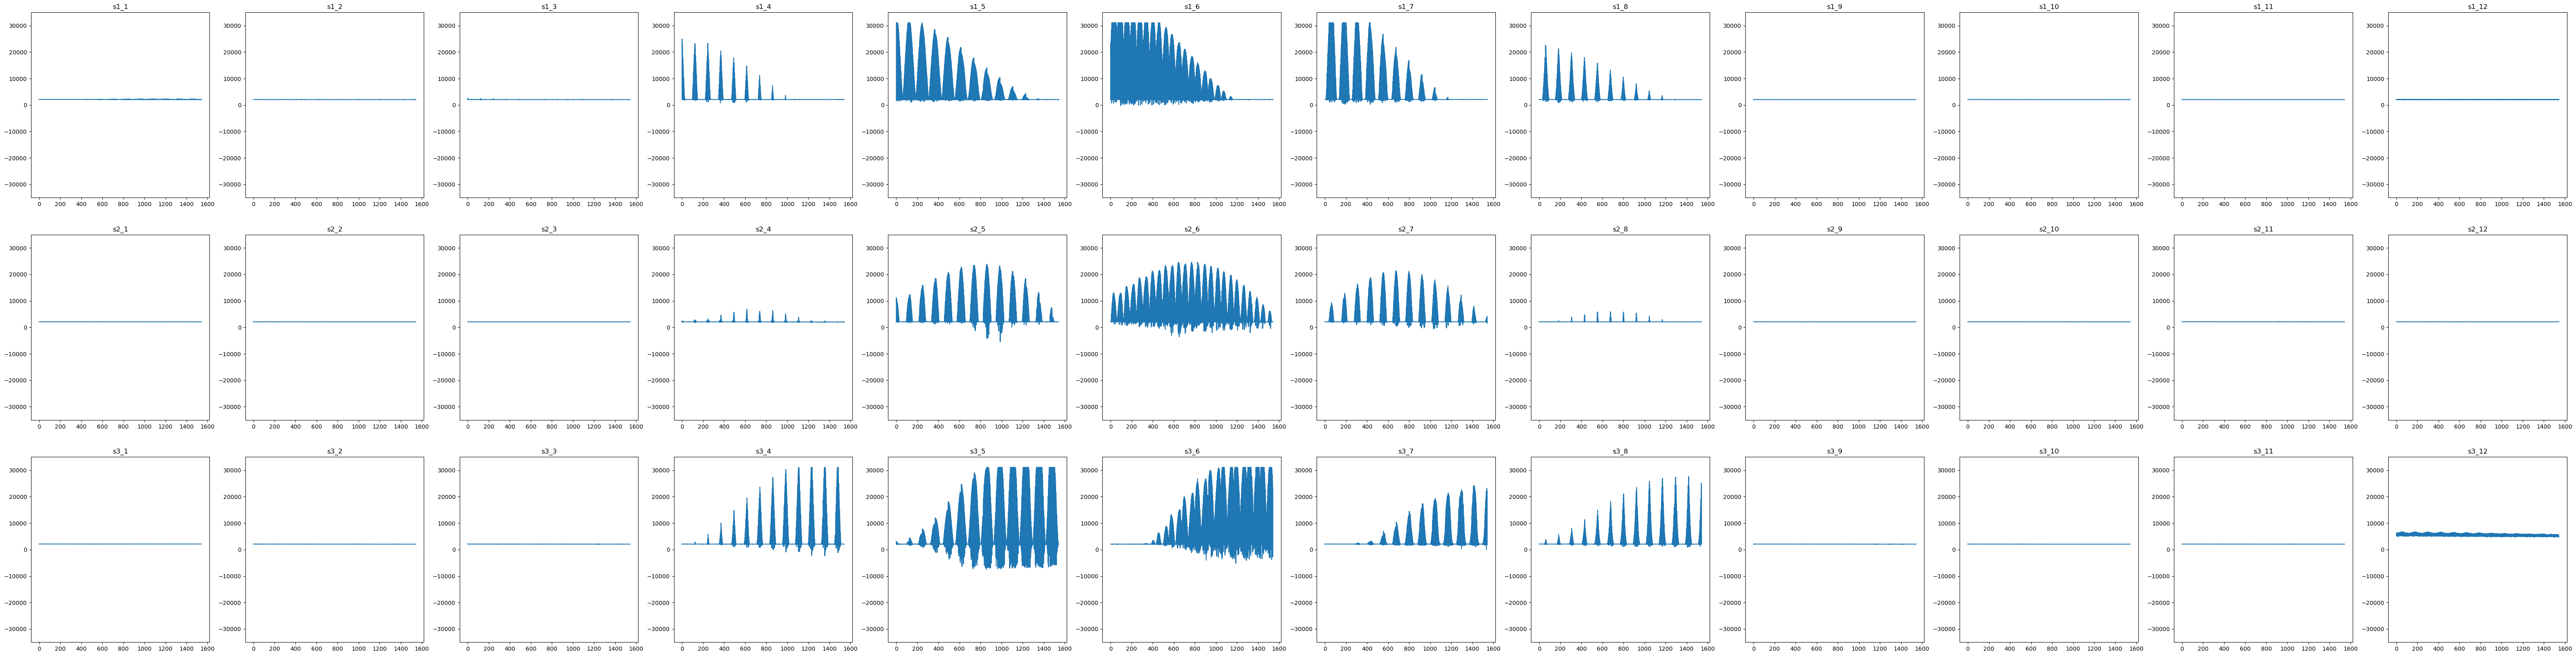

In [4]:
test_path = "data/2024-11-15_14-18-00.426253_LARGEDENSE_BP_COMBO"

# load data
data_path = os.path.join(test_path, "processed.npy")
key_path = os.path.join(test_path, "key.npy")
data, key = load_data(data_path, key_path)

plot_initial_data(data, key)

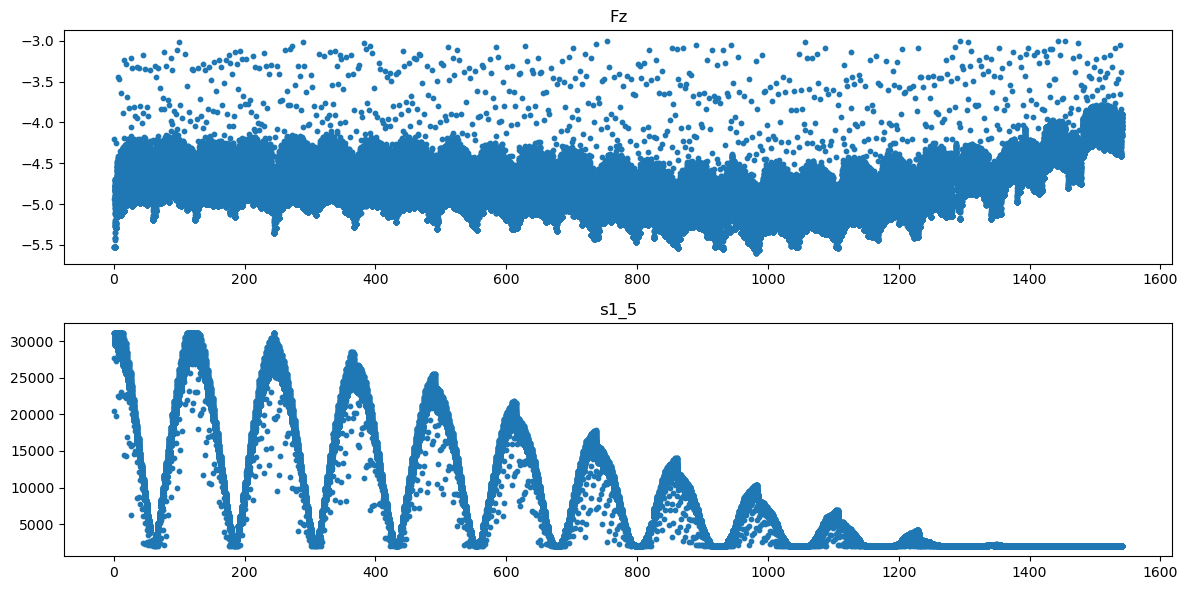

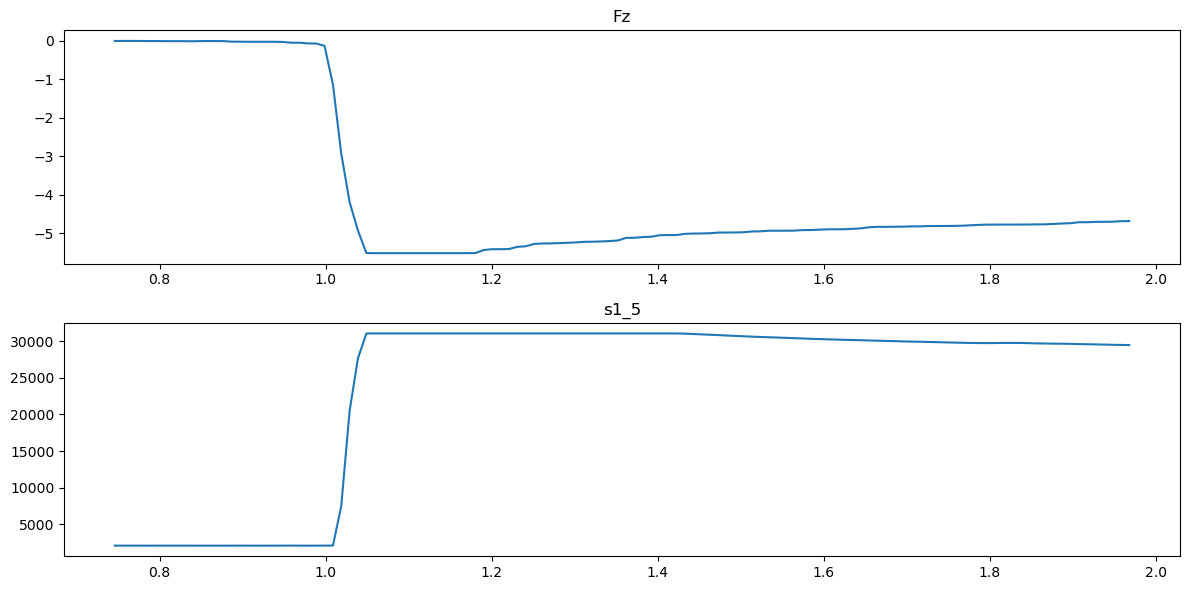

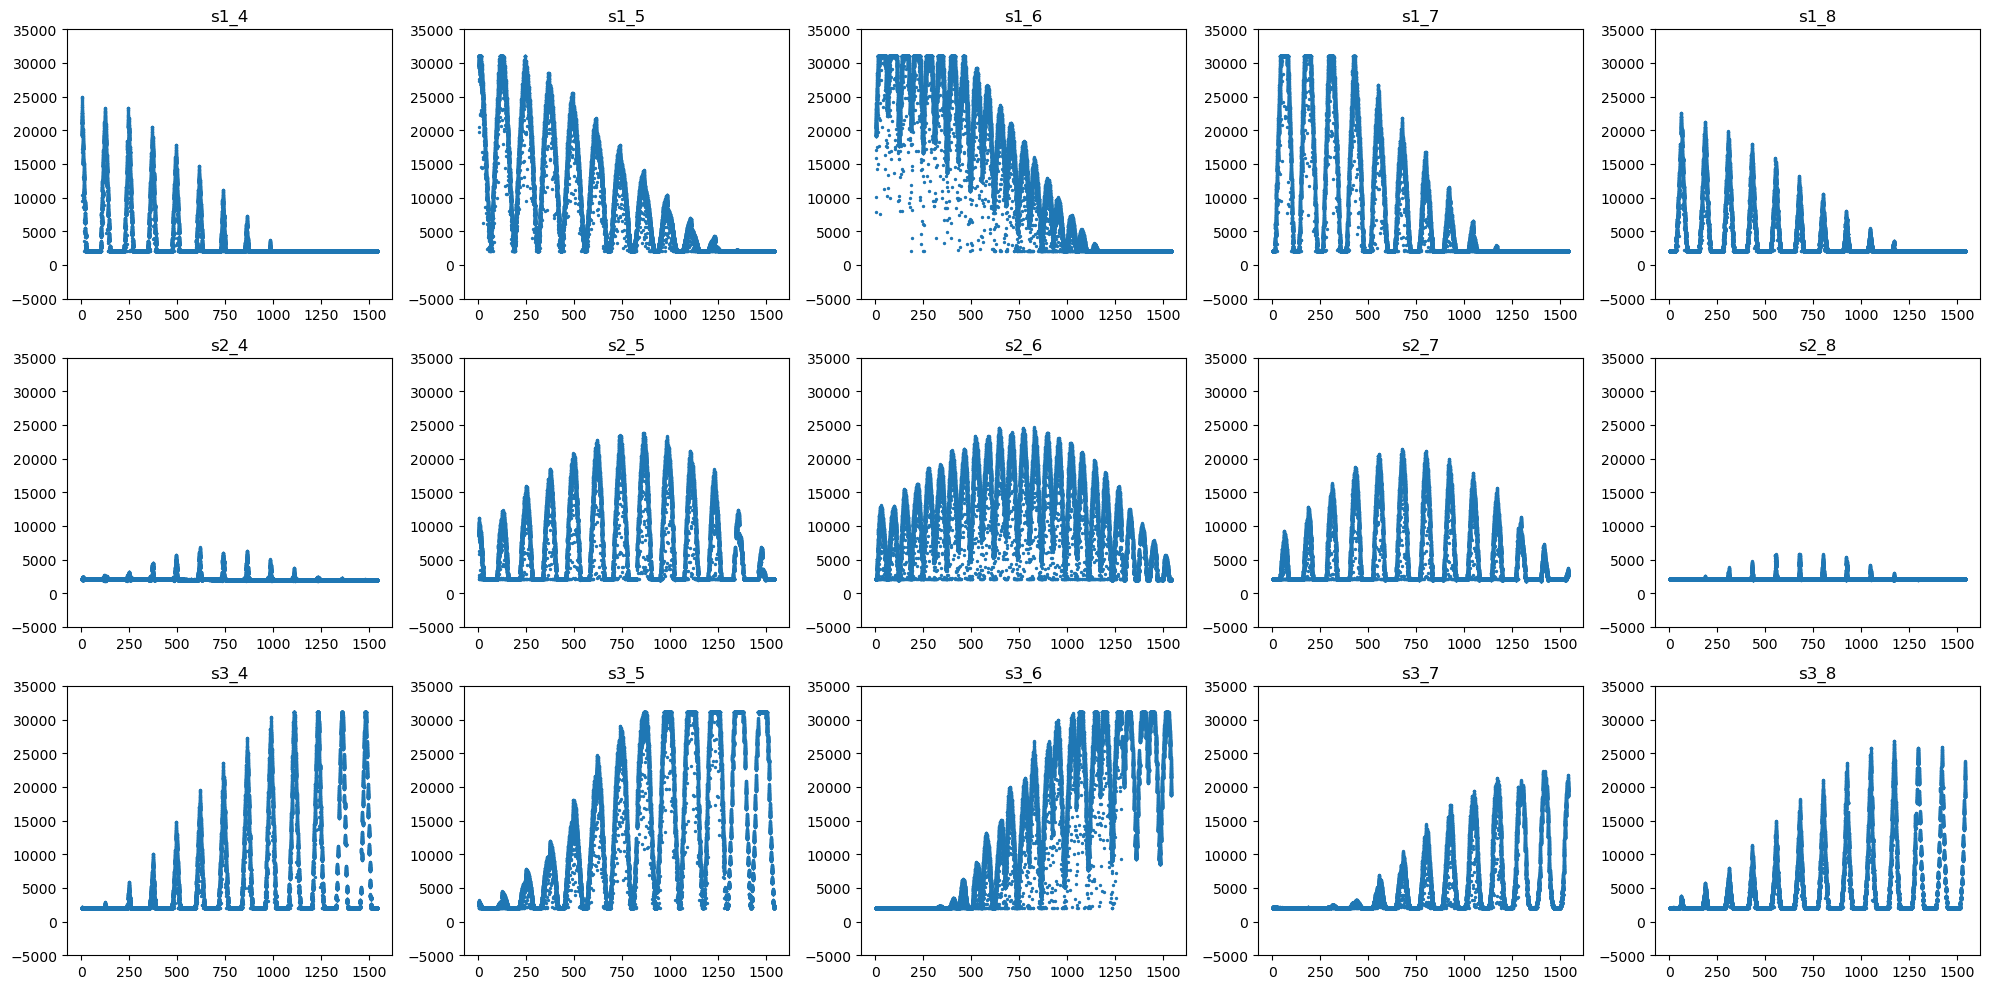

In [5]:
# PLOT PRESSURES FOR MIDDLE SECTION OF SENSOR ARRAY OVER ENTIRE TEST

# get data from trajectory points and higher force values
plot_data = data[data[:, key['point_idx']]>0]
plot_data = plot_data[plot_data[:, key['Fz']]<-3.0]

# just one sensor, all points
sensor_to_plot = 's1_5'
fig, ax = plt.subplots(2,1, figsize=(12,6))
ax[0].scatter(plot_data[:, key["time"]], plot_data[:, key["Fz"]], s=10)
ax[0].set_title("Fz")
ax[1].scatter(plot_data[:, key["time"]], plot_data[:, key[sensor_to_plot]], s=10)
ax[1].set_title(sensor_to_plot)
plt.tight_layout()
plt.show()

# just one sensor, one point
point_to_plot = 1
fig, ax = plt.subplots(2,1, figsize=(12,6))
point_data = data[data[:, key['point_idx']]==point_to_plot]
ax[0].plot(point_data[:, key["time"]], point_data[:, key["Fz"]])
ax[0].set_title("Fz")
ax[1].plot(point_data[:, key["time"]], point_data[:, key[sensor_to_plot]])
ax[1].set_title(sensor_to_plot)
plt.tight_layout()
plt.show()


# all of the sensors in the middle section
sensor_list  = ['s1_4', 's1_5', 's1_6', 's1_7', 's1_8', 
                's2_4', 's2_5', 's2_6', 's2_7', 's2_8', 
                's3_4', 's3_5', 's3_6', 's3_7', 's3_8']

fig, ax = plt.subplots(3,5, figsize=(20,10))
k = 0
for i in range(3):
    for j in range(5):
        cur_key = sensor_list[k]
        ax[i,j].scatter(plot_data[:, key["time"]], plot_data[:, key[cur_key]], s=2)
        ax[i,j].set_title(cur_key)
        ax[i,j].set_ylim(-5000, 35000)
        k += 1

plt.tight_layout()
plt.show()

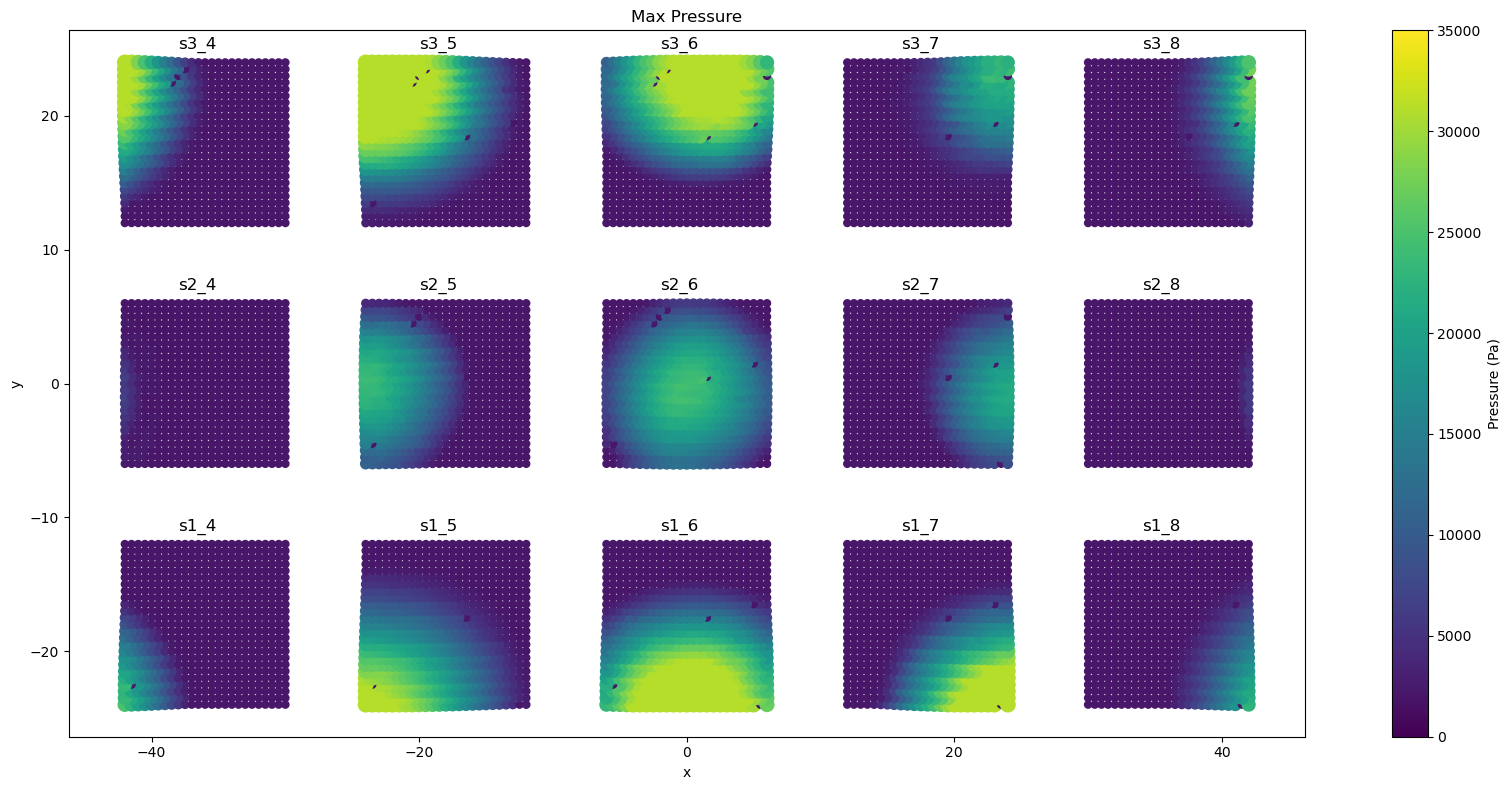

In [23]:
# HEATMAP OF PRESSURE VALUES FOR SPECIFIC SENSOR OVER ENTIRE TEST

# slice data

# sensor to plot
sensor_to_plot = 's2_6'

x_coords = np.linspace(-6, 6, 25)
y_coords = np.linspace(-6, 6, 25)

# pull out important values for heatmaps
num_pts = np.max(data[:, key['point_idx']]).astype(int)
x_act_locs = np.zeros(num_pts)
y_act_locs = np.zeros(num_pts)
x_des_locs = np.zeros(num_pts)
y_des_locs = np.zeros(num_pts)
max_pressures = np.zeros(num_pts)
median_pressures = np.zeros(num_pts)
for i in range(num_pts):
    cur_data = data[data[:, key['point_idx']]==i+1]
    x_act_locs[i] = np.mean(cur_data[:, key['x_act']])
    y_act_locs[i] = np.mean(cur_data[:, key['y1_act']])
    x_idx = i % 25
    y_idx = i // 25
    y_des_locs[i] = y_coords[y_idx]
    if y_idx % 2 == 0:
        x_des_locs[i] = x_coords[x_idx]
    else:
        x_des_locs[i] = x_coords[24-x_idx]
    max_pressures[i] = np.max(cur_data[:, key[sensor_to_plot]])
    median_pressures[i] = np.median(cur_data[:, key[sensor_to_plot]])
    # print(i, x_act_locs[i], y_act_locs[i], x_des_locs[i], y_des_locs[i], max_pressures[i], median_pressures[i])

# map presure values to dot sizes
def pressure_to_size(pressure):
    if (pressure < 0):
        return 0
    else:
        return 20 + 100*(pressure/35000)

# fig, ax = plt.subplots(1,1, figsize=(10,10))
# cax0 = ax.scatter(x_act_locs, y_act_locs, c=max_pressures, cmap='viridis')
# cbar = fig.colorbar(cax0, ax=ax)
# ax.set_title("Max Pressure, Sensor "+sensor_to_plot)
# plt.tight_layout()
# plt.show()

sizes = np.zeros(num_pts)
for p in range(num_pts):
    sizes[p] = pressure_to_size(max_pressures[p])

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# cax0 = ax.scatter(x_des_locs, y_des_locs, c=max_pressures, cmap='viridis', s=sizes)
# cbar = fig.colorbar(cax0, ax=ax)
# ax.set_title("Max Pressure, "+sensor_to_plot)
# ax.set_xlabel("x (mm)")
# ax.set_ylabel("y (mm)")
# ax.set_aspect('equal')
# plt.tight_layout()
# plt.show()

# now, plot heatmaps for all of the sensors
sensors_to_plot = ['s1_4', 's1_5', 's1_6', 's1_7', 's1_8',
                    's2_4', 's2_5', 's2_6', 's2_7', 's2_8',
                    's3_4', 's3_5', 's3_6', 's3_7', 's3_8']
sensor_offsets = [(-12,-6), (-6,-6), (0,-6), (6,-6), (12,-6),
                    (-12,0), (-6,0), (0,0), (6,0), (12,0),
                    (-12,6), (-6,6), (0,6), (6,6), (12,6)]
offset_scale = 3.0
x_act_locs_full = np.zeros((num_pts,15))
y_act_locs_full = np.zeros((num_pts,15))
x_des_locs_full = np.zeros((num_pts,15))
y_des_locs_full = np.zeros((num_pts,15))
max_pressures_full = np.zeros((num_pts,15))
median_pressures_full = np.zeros((num_pts,15))
sizes_full = np.zeros((num_pts,15))
for s, sensor_to_plot in enumerate(sensors_to_plot):
    for i in range(num_pts):
        cur_data = data[data[:, key['point_idx']]==i+1]
        max_pressures_full[i,s] = np.max(cur_data[:, key[sensor_to_plot]])
        sizes_full[i,s] = pressure_to_size(max_pressures_full[i,s])
        median_pressures_full[i,s] = np.median(cur_data[:, key[sensor_to_plot]])
    
    x_act_locs_full[:,s] = x_act_locs + offset_scale*sensor_offsets[s][0]
    y_act_locs_full[:,s] = y_act_locs + offset_scale*sensor_offsets[s][1]
    x_des_locs_full[:,s] = x_des_locs + offset_scale*sensor_offsets[s][0]
    y_des_locs_full[:,s] = y_des_locs + offset_scale*sensor_offsets[s][1]

# actually make plot
# # using subplots?
# fig, ax = plt.subplots(3,5, figsize=(20,10))
# for s, sensor_to_plot in enumerate(sensors_to_plot):
#     sizes = np.zeros(num_pts)
#     for p in range(num_pts):
#         sizes[p] = pressure_to_size(max_pressures_full[p,s])
#     cax0 = ax[2 - s//5,s%5].scatter(x_des_locs_full[:,s], y_des_locs_full[:,s], c=max_pressures_full[:,s], cmap='viridis', s=sizes)
#     ax[2 - s//5,s%5].set_title(sensor_to_plot)
#     # ax[2 - s//5,s%5].set_xlabel("x (mm)")
#     # ax[2 - s//5,s%5].set_ylabel("y (mm)")
#     ax[2 - s//5,s%5].set_aspect('equal')

# all on same plot, adding colorbar
fig, ax = plt.subplots(1,1, figsize=(18,8))
cax0 = ax.scatter(x_des_locs_full.ravel(), y_des_locs_full.ravel(), c=max_pressures_full.ravel(), cmap='viridis', clim=[0,35000], s=sizes_full.ravel())
for s, sensor_to_plot in enumerate(sensors_to_plot):
    ax.text(x=-2.0+offset_scale*sensor_offsets[s][0], y=7.0+offset_scale*sensor_offsets[s][1], s=sensor_to_plot, fontsize=12)
cbar = fig.colorbar(cax0, ax=ax)
cbar.set_label('Pressure (Pa)')
ax.set_title("Max Pressure")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

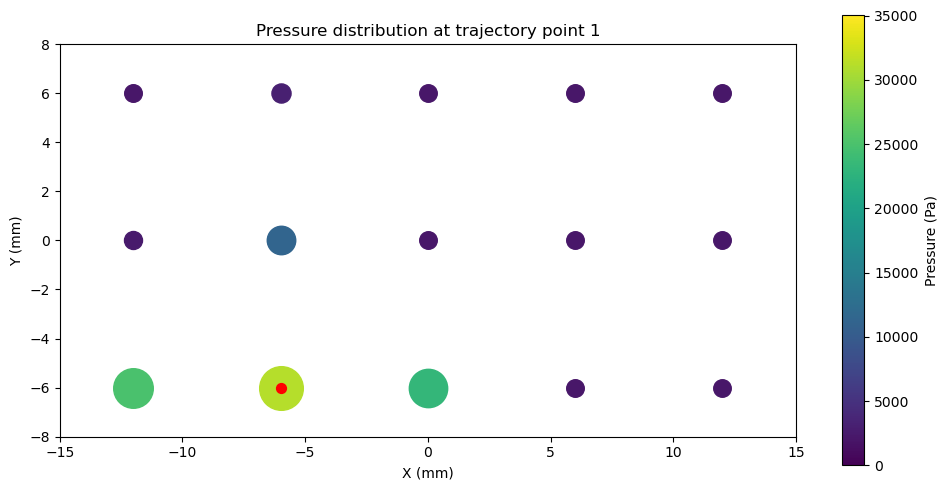

In [7]:
# ANIMATE PRESSURE DISTRIBUTION OVER TIME


# map presure values to dot sizes
def pressure_to_size(pressure):
    if (pressure < 0):
        return 0
    else:
        return 100 + 1000*(pressure/35000)

fig, ax = plt.subplots(1,1, figsize=(10,5))
cax1 = ax.scatter(x_des_locs_full[0,:], y_des_locs_full[0,:], c=max_pressures_full[0,:], cmap='viridis', clim=[0,35000], s=sizes_full[0,:])
cbar = fig.colorbar(cax1, ax=ax)
cbar.set_label('Pressure (Pa)')

pt_to_plot = 33
def update(pt_to_plot):
    ax.clear()
    for s, sensor_to_plot in enumerate(sensors_to_plot):
        pressure = max_pressures_full[pt_to_plot-1,s]
        size = pressure_to_size(pressure)
        ax.scatter(sensor_offsets[s][0], sensor_offsets[s][1], c=pressure, cmap='viridis', clim=[0,35000], s=size)
    # cax1 = ax.scatter(x_des_locs[pt_to_plot-1,:], y_des_locs_full[pt_to_plot-1,:], c=max_pressures_full[pt_to_plot-1,:], cmap='viridis', clim=[0,35000], s=sizes_full[pt_to_plot-1,:])
    cax2 = ax.scatter(x_des_locs[pt_to_plot-1], y_des_locs[pt_to_plot-1], c='r', s=50)
    ax.set_title("Pressure distribution at trajectory point "+str(pt_to_plot))
    ax.set_xlabel("X (mm)")
    ax.set_xlim(-15,15)
    ax.set_ylabel("Y (mm)")
    ax.set_ylim(-8,8)
    ax.set_aspect('equal')
    plt.tight_layout()
# plt.show()

ani = animation.FuncAnimation(fig, update, frames=range(1,num_pts+1), interval=40, repeat=False)
# ani.save('dense_middle_grid_pressure_distribution.gif', writer='imagemagick')
HTML(ani.to_html5_video())



[301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325]


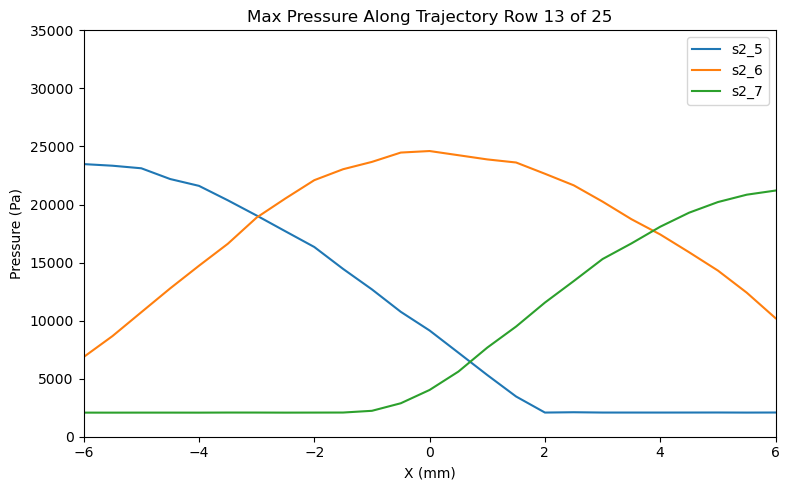

[ 13.  38.  63.  88. 113. 138. 163. 188. 213. 238. 263. 288. 313. 338.
 363. 388. 413. 438. 463. 488. 513. 538. 563. 588. 613.]


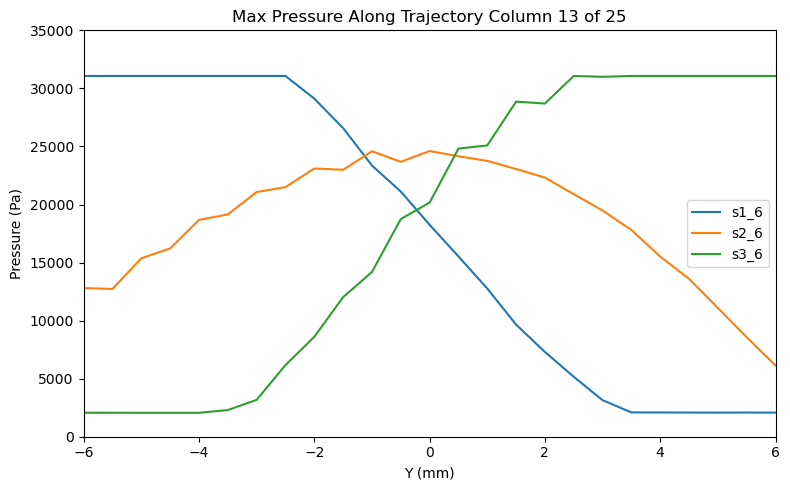

In [29]:
# slice along one row of trajectory points
row_idx = 12
traj_row_pts = np.arange(1,26) + row_idx*25
print(traj_row_pts)
# and plot the middle row of sensors
sensors_to_plot = ['s2_5', 's2_6', 's2_7']
max_pressures = np.zeros((3,25))
for i, sensor_to_plot in enumerate(sensors_to_plot):
    for j, pt in enumerate(traj_row_pts):
        cur_data = data[data[:, key['point_idx']]==pt]
        max_pressures[i,j] = np.max(cur_data[:, key[sensor_to_plot]])

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(x_coords, max_pressures[0,:], label=sensors_to_plot[0])
ax.plot(x_coords, max_pressures[1,:], label=sensors_to_plot[1])
ax.plot(x_coords, max_pressures[2,:], label=sensors_to_plot[2])
ax.set_title("Max Pressure Along Trajectory Row "+str(row_idx+1)+" of 25")
ax.set_xlabel("X (mm)")
ax.set_xlim(-6, 6)
ax.set_ylabel("Pressure (Pa)")
ax.set_ylim(0, 35000)
ax.legend()
plt.tight_layout()
plt.show()

# now, slice along middle column of the trajectory
col_idx = 12
traj_col_pts = np.zeros(25)
for i in range(25):
    if i % 2 == 0:
        traj_col_pts[i] = i*25 + col_idx + 1
    else:
        traj_col_pts[i] = i*25 + 25 - col_idx
print(traj_col_pts)
# and plot the middle column of sensors
sensors_to_plot = ['s1_6', 's2_6', 's3_6']
max_pressures = np.zeros((3,25))
for i, sensor_to_plot in enumerate(sensors_to_plot):
    for j, pt in enumerate(traj_col_pts):
        cur_data = data[data[:, key['point_idx']]==pt]
        max_pressures[i,j] = np.max(cur_data[:, key[sensor_to_plot]])

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(y_coords, max_pressures[0,:], label=sensors_to_plot[0])
ax.plot(y_coords, max_pressures[1,:], label=sensors_to_plot[1])
ax.plot(y_coords, max_pressures[2,:], label=sensors_to_plot[2])
ax.set_title("Max Pressure Along Trajectory Column "+str(col_idx+1)+" of 25")
ax.set_xlabel("Y (mm)")
ax.set_xlim(-6, 6)
ax.set_ylabel("Pressure (Pa)")
ax.set_ylim(0, 35000)
ax.legend()
plt.tight_layout()
plt.show()

